In [2]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
import math

import time

In [3]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r * 1000 # to have the distance in meters

In [4]:
class GWR:
    def __init__(self, bandwidth=1.0):
        self.bandwidth = bandwidth

    def _gaussian_kernel(self, distances):
        weights = np.exp(-(distances ** 2) / (2 * self.bandwidth ** 2))
        return weights / np.sum(weights, axis=1, keepdims=True)

    def fit(self, X, y, coordinates):
        self.X = X
        self.y = y
        self.coordinates = coordinates

    def predict(self, X_pred, coord):
        y_pred = np.zeros(X_pred.shape[0])
        for i, x in enumerate(X_pred):
            print(X_pred[i])
            print(coord[i])
            # print(x)
            distances = cdist(coord[i], self.coordinates)
            weights = self._gaussian_kernel(distances)
            local_X = np.concatenate((np.ones((self.X.shape[0], 1)), self.X), axis=1)
            local_X_weighted = local_X * weights
            local_y_weighted = self.y * weights.squeeze()
            beta = np.linalg.lstsq(local_X_weighted, local_y_weighted, rcond=None)[0]
            y_pred[i] = np.dot(np.concatenate(([1], x)), beta)
        return y_pred

In [5]:

class GWR:
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth

    def _gaussian_kernel(self, h, dist):
        return np.exp(-(dist ** 2) / (2 * h ** 2))

    def _kernel_weights(self, coords, coord, h):
        dists = np.linalg.norm(coords - coord, axis=1)
        weights = self._gaussian_kernel(h, dists)
        return weights / np.sum(weights)

    def fit(self, coords, y, X):
        n = len(y)
        coefficients = np.zeros((n, X.shape[1]))
        
        for i, coord in enumerate(coords):
            w = self._kernel_weights(coords, coord, self.bandwidth)
            W = np.diag(w)
            XW = np.dot(W, X)
            yW = np.dot(W, y)
            beta = np.linalg.lstsq(XW, yW, rcond=None)[0]
            coefficients[i] = beta
        
        self.coefficients = coefficients

    def predict(self, new_coords, new_X):
        predictions = []
        for coord in new_coords:
            # weights = self._kernel_weights(self.coords, coord, self.bandwidth)
            pred = np.dot(self.coefficients, new_X.T).mean(axis=0)
            predictions.append(pred)
        return np.array(predictions)

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

class GWR:
    def __init__(self, bandwidth, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        self.coefficients = None

    def _gaussian_kernel(self, dist):
        return np.exp(-0.5 * (dist / self.bandwidth) ** 2)

    def _kernel_weights(self, coords, coord):
        dists = np.linalg.norm(coords - coord, axis=1)
        weights = self._gaussian_kernel(dists)
        return weights

    def fit(self, coords, X, y):
        n, m = X.shape
        self.coefficients = np.zeros((n, m + 1))
        
        for i, coord in enumerate(coords):
            weights = self._kernel_weights(coords, coord)
            W = np.diag(weights)
            X_w = np.dot(W, X)
            y_w = np.dot(W, y)
            X_w = np.insert(X_w, 0, 1, axis=1)  # Add intercept term
            
            # Solve for coefficients using weighted least squares
            XtX = np.dot(X_w.T, X_w)
            Xty = np.dot(X_w.T, y_w)
            beta = np.linalg.solve(XtX, Xty)
            self.coefficients[i] = beta

    def predict(self, coords, X):
        X = np.insert(X, 0, 1, axis=1)  # Add intercept term
        predictions = np.zeros(len(X))
        
        for i, coord in enumerate(coords):
            weights = self._kernel_weights(coords, coord)
            k = X.T * weights
            pred = np.dot(self.coefficients.T, k)
            predictions[i] = np.sum(pred)
        
        return predictions

In [7]:

with open('../Data/2023_edges_extended_header.csv', 'r') as file:
    columns = file.readline().strip().split(',') 
df_edges = pd.read_csv('../Data/2023_edges_extended.csv', header=None)
df_edges.columns = columns




In [8]:
# df_edges_small = df_edges[:40]

In [9]:
departure_counts = df_edges.groupby([":START_ID", "startlatitude:float","startlongitude:float","temperature","wind_speed","good_weather","year","month","day","hour"]).size().reset_index(name='count')
arrival_counts = df_edges.groupby([":END_ID", "endlatitude:float","endlongitude:float","temperature","wind_speed","good_weather","year","month","day","hour"]).size().reset_index(name='count')

In [10]:
departure_counts[departure_counts["count"] > 1]

,:START_ID,startlatitude:float,startlongitude:float,temperature,wind_speed,good_weather,year,month,day,hour,count
0,0,45.524236,-73.581552,-12.0,10.0,1.0,2023,11,25,1,4
1,0,45.524236,-73.581552,-12.0,10.0,1.0,2023,12,7,3,2
3,0,45.524236,-73.581552,-11.0,5.0,1.0,2023,12,7,5,2
4,0,45.524236,-73.581552,-11.0,10.0,1.0,2023,11,24,23,11
5,0,45.524236,-73.581552,-11.0,10.0,1.0,2023,11,25,0,10
...,...,...,...,...,...,...,...,...,...,...,...
2520961,1318885,45.447133,-73.603332,21.0,20.0,0.0,2023,8,10,18,2
2520963,1318885,45.447133,-73.603332,24.0,20.0,0.0,2023,8,10,16,2
2520964,2197094,45.523970,-73.585075,20.0,10.0,1.0,2023,8,22,11,6
2520966,4941087,45.535426,-73.513659,19.0,10.0,0.0,2023,6,28,1,3


In [11]:
departure_counts_locationfree = df_edges.groupby(["temperature","wind_speed","good_weather","year","month","day","hour"]).size().reset_index(name='count')
arrival_counts_locationfree = df_edges.groupby(["temperature","wind_speed","good_weather","year","month","day","hour"]).size().reset_index(name='count')

In [12]:
departure_counts_locationfree[departure_counts["count"] > 1]

C:\Users\Chaubi\AppData\Local\Temp\ipykernel_9172\2828236866.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  departure_counts_locationfree[departure_counts["count"] > 1]


,temperature,wind_speed,good_weather,year,month,day,hour,count
0,-12.0,5.0,1.0,2023,12,7,6,16
1,-12.0,5.0,1.0,2023,12,7,7,8
3,-12.0,10.0,1.0,2023,12,7,3,67
4,-12.0,10.0,1.0,2023,12,7,4,60
5,-11.0,5.0,1.0,2023,12,7,5,34
...,...,...,...,...,...,...,...,...
6308,32.0,10.0,1.0,2023,9,6,17,3062
6309,32.0,15.0,1.0,2023,7,6,16,2875
6311,32.0,20.0,1.0,2023,6,1,15,2184
6313,34.0,20.0,1.0,2023,6,1,16,2701


In [26]:

# Sample the dataset
partial_departure_counts = departure_counts.sample(frac=1, random_state=42)
partial_departure_counts_test = partial_departure_counts.sample(frac=0.2, random_state=42)
partial_departure_counts_train = partial_departure_counts.drop(partial_departure_counts_test.index)

In [ ]:

# departure_counts.values
feature_columns = ["temperature","wind_speed","good_weather","year","month","day","hour"] # features
target_column = 'count'  # target
coordinate_columns = ['startlatitude:float', 'startlongitude:float']  # coordinates
X = partial_departure_counts[feature_columns].values
y = partial_departure_counts[target_column].values
coordinates = partial_departure_counts[coordinate_columns].values
# Split the dataset 
X_train, X_test, y_train, y_test, coord_train, coord_test = train_test_split(
    X, y, coordinates, test_size=0.2, random_state=42
)
# print(X_train, X_test, y_train, y_test, coord_train, coord_test)
# Create and train the model
gwr_model = GWR(bandwidth=0.1)  # Adjust bandwidth as needed
gwr_model.fit(coord_train, X_train, y_train)
# Make predictions
predictions = gwr_model.predict(coord_test, X_test)
# Merge predictions with X_test
X_test_with_predictions = np.hstack((X_test, predictions.reshape(-1, 1)))
print("X_test with predictions:")
print(X_test_with_predictions)
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.metrics import mean_squared_error


y = partial_departure_counts_train['count'].values.reshape((-1,1)) # reshape is needed to have column array
print(y.shape)

X = partial_departure_counts_train[["temperature", "wind_speed", "good_weather", "year", "month", "day", "hour"]].values
# X = np.insert(X, 0, 1, axis=1)  
print(X.shape)

u = partial_departure_counts_train['startlatitude:float']
v = partial_departure_counts_train['startlongitude:float']
coords = list(zip(u,v))
# Select bandwidth for GWR
start_time = time.time()
selector = Sel_BW(coords, y, X)
bw = selector.search()
end_time = time.time()
print("selector time:", end_time - start_time)

# Fit the GWR model
gwr_model = GWR(coords, y, X, bw)
start_time = time.time()
gwr_results = gwr_model.fit()
end_time = time.time()
print("training time:", end_time - start_time)
# Print GWR results
gwr_results.summary()

y_test = partial_departure_counts_test['count'].values.reshape((-1,1)) # reshape is needed to have column array
print(y_test.shape)

X_test = partial_departure_counts_test[["temperature", "wind_speed", "good_weather", "year", "month", "day", "hour"]].values
print(X_test.shape)
# partial_departure_counts_train
u = partial_departure_counts_test['startlatitude:float']
v = partial_departure_counts_test['startlongitude:float']
coord_test = np.array(list(zip(u,v)))
print(coord_test)
print(coord_test.shape)
# Predict using the GWR model


start_time = time.time()
y_pred = gwr_model.predict(coord_test, X_test[:, 1:])
end_time = time.time()
print("predict time:", end_time - start_time)
y_pred = y_pred.predictions.flatten()
y_test = np.array(y_test).flatten()
# print(y_pred)
# print(y_test)

dist_y_test_y_pred = np.sum(abs(y_test - y_pred)) / len(y_test) 
print(dist_y_test_y_pred)
# print(np.array(y_test).flatten())
# corr = np.corrcoef(pred_results.predictions.flatten(), np.array(y_test).flatten())[0][1]
# print(corr)
# Evaluate the model
# mse = mean_squared_error(np.array(y_test), np.array(predictions))
# print(f"Mean Squared Error: {mse}")


(100839, 1)
(100839, 7)


KeyboardInterrupt: 

In [15]:
from scipy.stats import t

class MultipleLinearRegression:
    def __init__(self, alpha=0.01):
        self.coefficients = None
        self.alpha = alpha  # Regularization parameter

    def fit(self, X, y):
        start_time = time.time()
        
        # Add a column of ones for the intercept term
        X = np.insert(X, 0, 1, axis=1)

        # Compute coefficients using the normal equation with regularization
        I = np.eye(X.shape[1])
        I[0, 0] = 0  # Do not regularize the intercept term
        self.coefficients = np.linalg.inv(X.T @ X + self.alpha * I) @ X.T @ y

        end_time = time.time()
        self.training_time = end_time - start_time

    def predict(self, X):
        start_time = time.time()

        # Add a column of ones for the intercept term
        X = np.insert(X, 0, 1, axis=1)

        if self.coefficients is None:
            raise ValueError("Model has not been trained yet. Please call fit() first.")
        
        predictions = X @ self.coefficients

        end_time = time.time()
        self.prediction_time = end_time - start_time

        return predictions

    def summary(self, X, y):
        if self.coefficients is None:
            raise ValueError("Model has not been trained yet. Please call fit() first.")
        
        X = np.insert(X, 0, 1, axis=1)
        n = X.shape[0]
        k = X.shape[1]

        # Predicted values
        y_pred = X @ self.coefficients

        # Residuals
        residuals = y - y_pred

        # Degrees of freedom
        df_total = n - 1
        df_model = k - 1
        df_residual = n - k

        # Sum of squares
        ss_total = np.sum((y - np.mean(y))**2)
        ss_residual = np.sum(residuals**2)
        ss_model = ss_total - ss_residual

        # Mean sum of squares
        ms_model = ss_model / df_model
        ms_residual = ss_residual / df_residual

        # R-squared and Adjusted R-squared
        r_squared = 1 - (ss_residual / ss_total)
        adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / df_residual)

        # Standard error of the coefficients
        var_b = ms_residual * np.linalg.inv(X.T @ X + self.alpha * np.eye(k))
        se_b = np.sqrt(np.diag(var_b))

        # t-values for the coefficients
        t_values = self.coefficients / se_b

        # p-values for the coefficients
        p_values = [2 * (1 - t.cdf(np.abs(i), df_residual)) for i in t_values]

        # F-statistic
        f_statistic = ms_model / ms_residual
        f_pvalue = 1 - t.cdf(f_statistic, df_model)

        summary_table = pd.DataFrame({
            "Coefficients": self.coefficients,
            "Standard Errors": se_b,
            "t-values": t_values,
            "p-values": p_values
        })

        metrics = {
            "R-squared": r_squared,
            "Adjusted R-squared": adj_r_squared,
            "F-statistic": f_statistic,
            "F-statistic p-value": f_pvalue
        }

        return summary_table, metrics

In [28]:
feature_columns = ['startlatitude:float', 'startlongitude:float', "temperature","wind_speed","good_weather","year","month","day","hour"] # features
target_column = 'count'  # target
X = departure_counts[feature_columns].values
y = departure_counts[target_column].values
# Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

lr_model = MultipleLinearRegression()
lr_model.fit(X_train, y_train)
# Make predictions
# X_test = [6, 7, 8, 9, 10]
y_pred = lr_model.predict(X_test)
# print(y_pred)
dist_y_test_y_pred = np.sum(abs(y_test - y_pred)) / len(y_test)
print(dist_y_test_y_pred)
# dist_y_test_y_pred2 = np.linalg.norm(y_test - y_pred)
# print(dist_y_test_y_pred2)
# print("Predictions:", np.hstack((X_test, y_pred.reshape(-1, 1))))

summary_table, metrics = lr_model.summary(X_test, y_test)

print("Summary Table:\n", summary_table)
print("\nMetrics:\n", metrics)

print("\nTraining time (seconds):", lr_model.training_time)
print("Prediction time (seconds):", lr_model.prediction_time)

3.1878727983038435
Summary Table:
    Coefficients  Standard Errors    t-values      p-values
0  -6586.450767        47.850046 -137.647742  0.000000e+00
1     -9.465038         0.218510  -43.316276  0.000000e+00
2     20.852216         0.203598  102.418375  0.000000e+00
3      0.076152         0.000969   78.548105  0.000000e+00
4     -0.065452         0.001209  -54.139329  0.000000e+00
5      0.624686         0.014724   42.427523  0.000000e+00
6      4.228579         0.025336  166.902235  0.000000e+00
7     -0.047051         0.003410  -13.797102  0.000000e+00
8     -0.005782         0.000784   -7.371466  1.689759e-13
9      0.130762         0.000952  137.283273  0.000000e+00

Metrics:
 {'R-squared': 0.08345961129973611, 'Adjusted R-squared': 0.08344325051252843, 'F-statistic': 5101.197774919828, 'F-statistic p-value': 0.0}

Training time (seconds): 0.22099971771240234
Prediction time (seconds): 0.03000783920288086


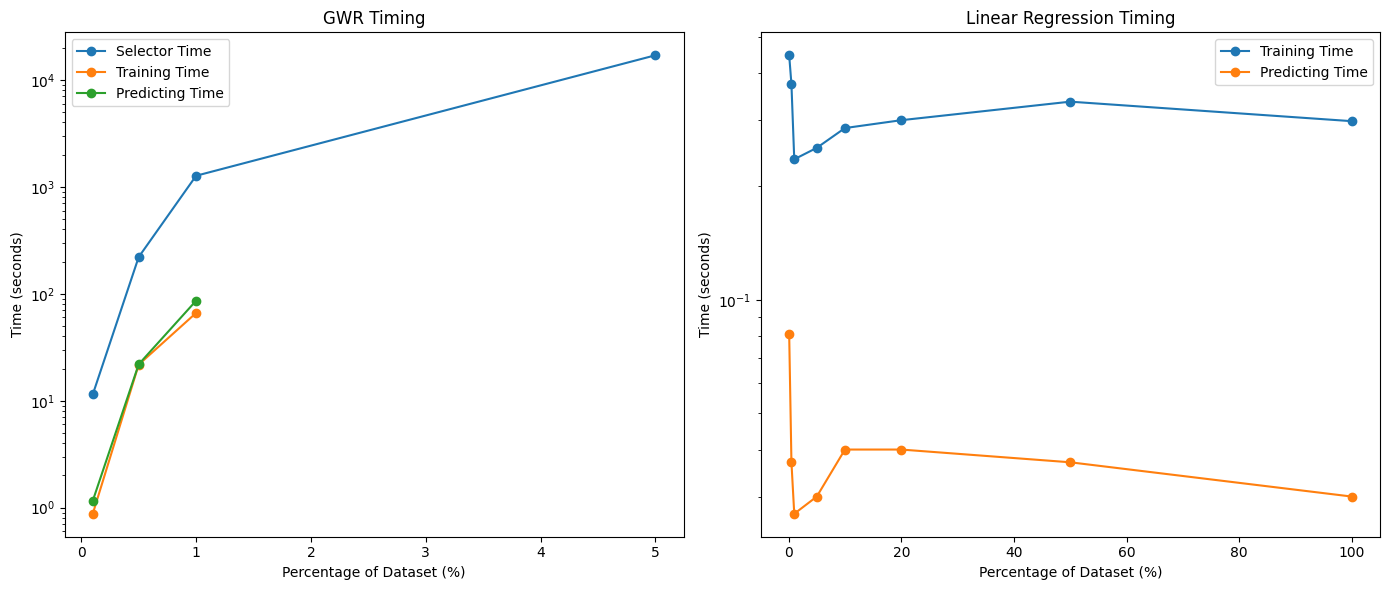

In [29]:
import matplotlib.pyplot as plt

# GWR data
gwr_percentage = [0.1, 0.5, 1, 5]
gwr_selector = [11.4440, 220.6656, 1269.7351, 17000]
gwr_training = [0.8760, 21.7572, 66.2150]
gwr_predicting = [1.1584, 21.9033, 86.1812]

# Linear Regression data
lr_percentage = [0.1, 0.5, 1, 5, 10, 20, 50, 100]
lr_training = [0.4463, 0.3737, 0.2362, 0.2533, 0.2859, 0.3000, 0.3360, 0.2982]
lr_predicting = [0.0810, 0.0370, 0.0270, 0.0300, 0.0400, 0.0400, 0.0370, 0.0300]

# Plotting GWR
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(gwr_percentage, gwr_selector, marker='o', label='Selector Time')
plt.plot(gwr_percentage[:3], gwr_training, marker='o', label='Training Time')
plt.plot(gwr_percentage[:3], gwr_predicting, marker='o', label='Predicting Time')
plt.xlabel('Percentage of Dataset (%)')
plt.ylabel('Time (seconds)')
plt.title('GWR Timing')
plt.legend()
plt.yscale('log')

# Plotting Linear Regression
plt.subplot(1, 2, 2)
plt.plot(lr_percentage, lr_training, marker='o', label='Training Time')
plt.plot(lr_percentage, lr_predicting, marker='o', label='Predicting Time')
plt.xlabel('Percentage of Dataset (%)')
plt.ylabel('Time (seconds)')
plt.title('Linear Regression Timing')
plt.legend()
plt.yscale('log')

plt.tight_layout()
plt.show()

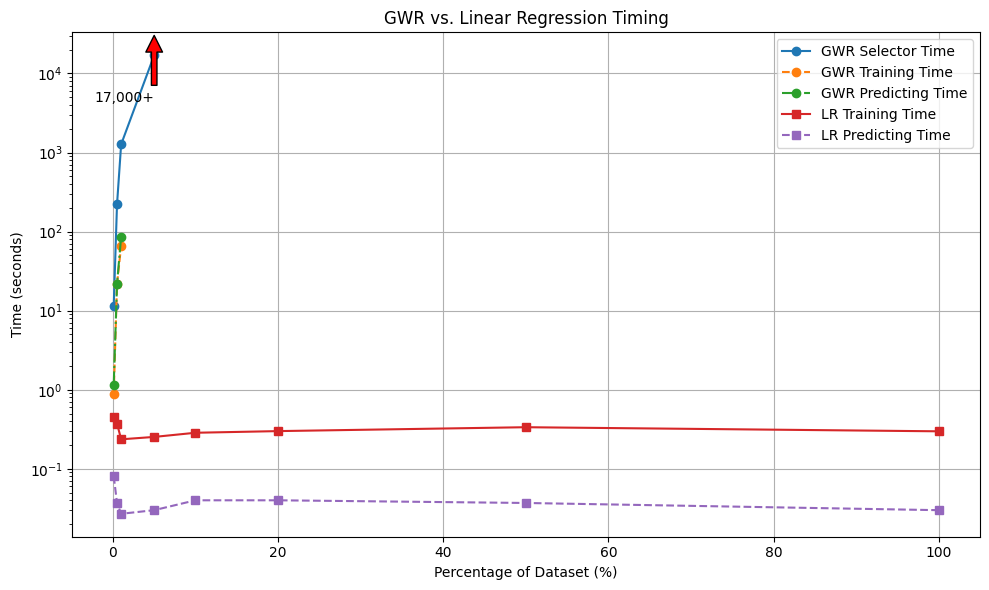

In [45]:
import matplotlib.pyplot as plt

# GWR data
gwr_percentage = [0.1, 0.5, 1, 5]
gwr_selector = [11.4440, 220.6656, 1269.7351, 17000]
gwr_training = [0.8760, 21.7572, 66.2150]
gwr_predicting = [1.1584, 21.9033, 86.1812]

# Linear Regression data
lr_percentage = [0.1, 0.5, 1, 5, 10, 20, 50, 100]
lr_training = [0.4463, 0.3737, 0.2362, 0.2533, 0.2859, 0.3000, 0.3360, 0.2982]
lr_predicting = [0.0810, 0.0370, 0.0270, 0.0300, 0.0400, 0.0400, 0.0370, 0.0300]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot GWR data
plt.plot(gwr_percentage, gwr_selector, 'o-', label='GWR Selector Time')
plt.plot(gwr_percentage[:3], gwr_training, 'o--', label='GWR Training Time')
plt.plot(gwr_percentage[:3], gwr_predicting, 'o-.', label='GWR Predicting Time')

# Mark the outlier
plt.annotate('17,000+', xy=(5, 33000), xytext=(5, 6000),
             arrowprops=dict(facecolor='red', shrink=0.05),
             horizontalalignment='right', verticalalignment='top')

# Plot Linear Regression data
plt.plot(lr_percentage, lr_training, 's-', label='LR Training Time')
plt.plot(lr_percentage, lr_predicting, 's--', label='LR Predicting Time')

# Labels and title
plt.xlabel('Percentage of Dataset (%)')
plt.ylabel('Time (seconds)')
plt.title('GWR vs. Linear Regression Timing')
plt.yscale('log')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
